In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tqdm.auto import tqdm

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D

from skimage import measure
from skimage import draw
from centroidtracker import CentroidTracker
from csbdeep.io import save_tiff_imagej_compatible

import os
from pathlib import Path

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/stardist/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/stardist/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/stardist/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  

In [2]:
X = sorted(glob('training/img/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

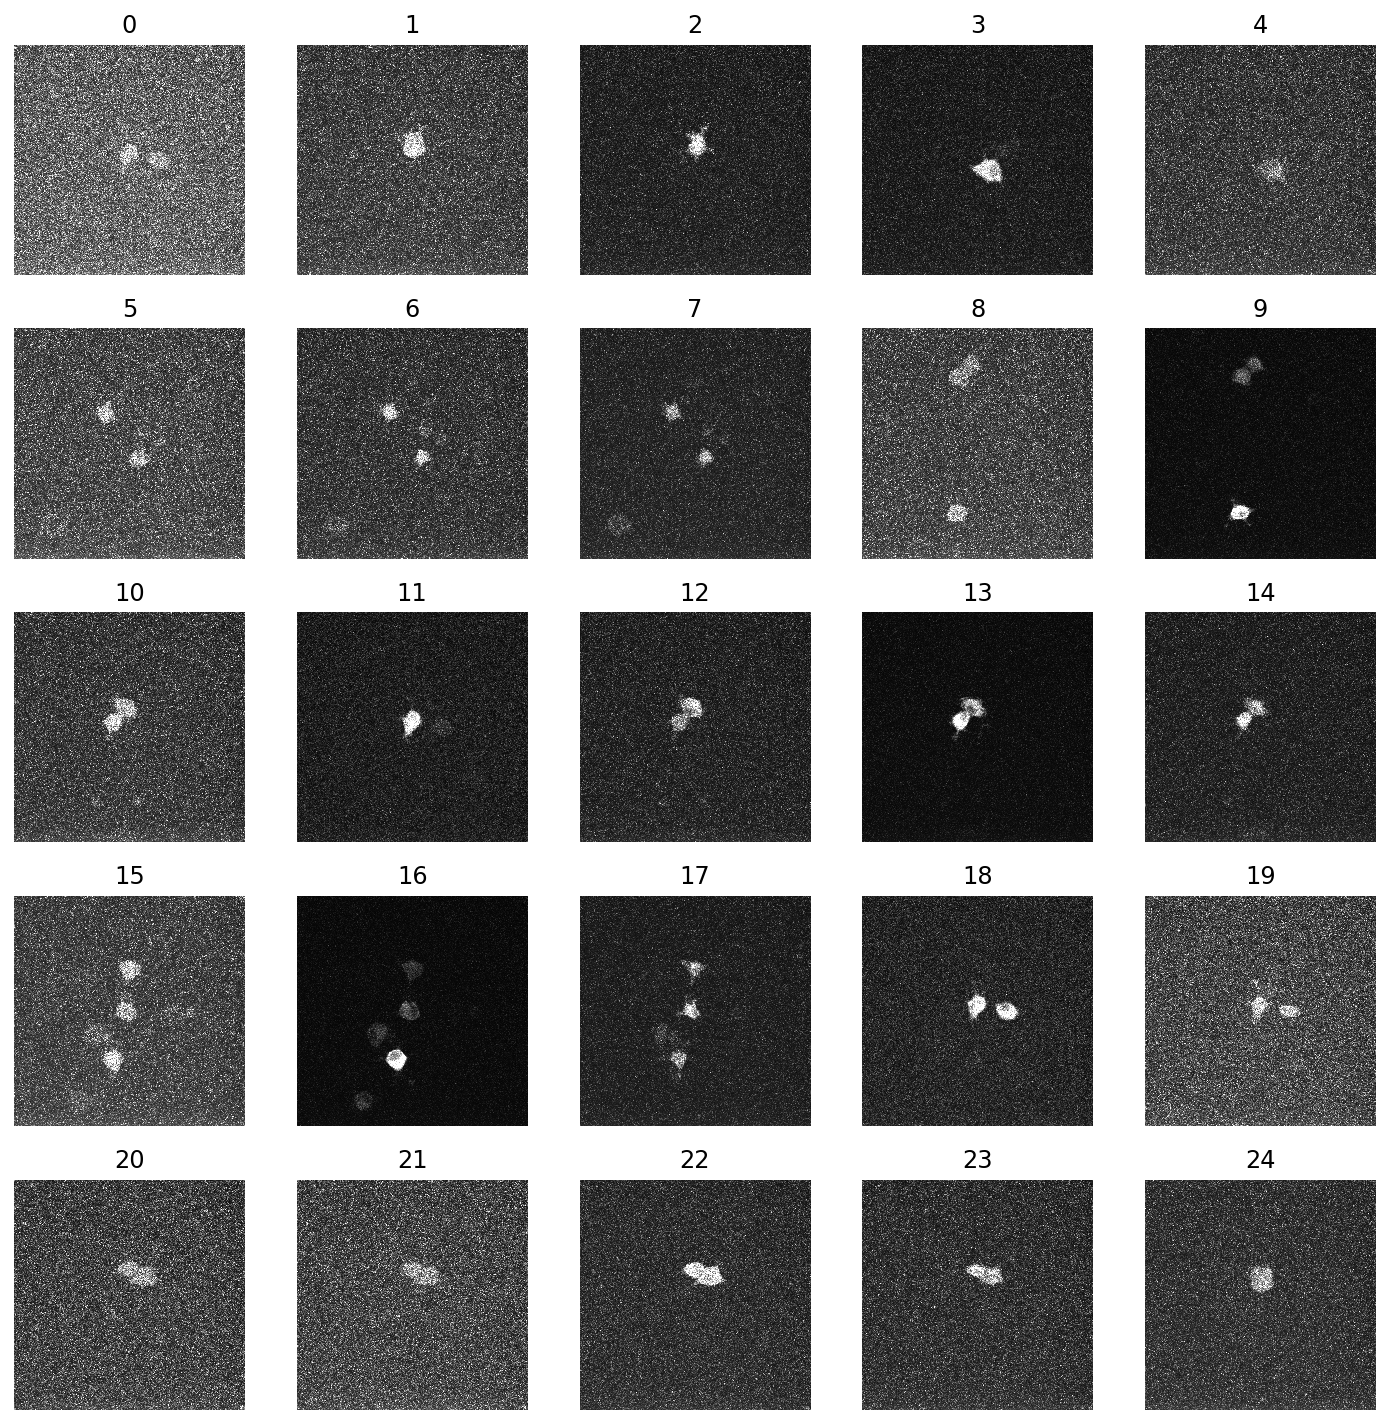

In [3]:
# show all test images
if True:
    fig, ax = plt.subplots(5,5, figsize=(10,10))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x,cmap='gray',vmin=np.min(x),vmax=0.5*np.max(x))
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [3]:
model = StarDist2D(None, name='gcamp-stardist', basedir='models')

Instructions for updating:
Colocations handled automatically by placer.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.548407, nms_thresh=0.3.


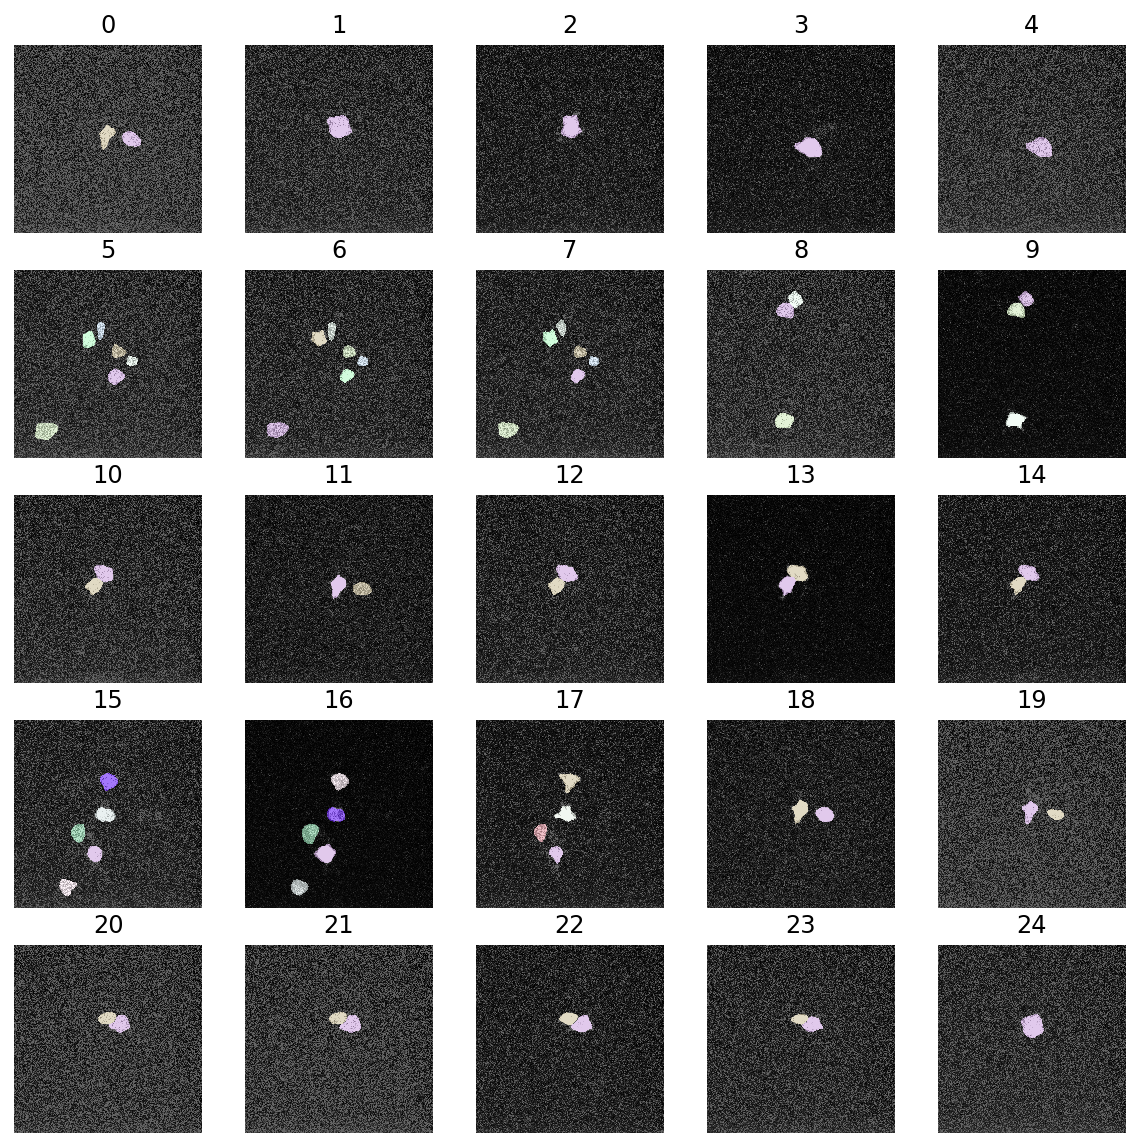

In [5]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
for i,(a,x) in enumerate(zip(ax.flat, X)):
    img = normalize(x,1,99.8,axis=(0,1))
    labels, details = model.predict_instances(img)
    a.imshow(img if img.ndim==2 else img[...,:3], clim=(0,0.3), cmap='gray')
    a.imshow(labels, cmap=lbl_cmap, alpha=0.6)
    a.set_title(i)
    a.axis('off');

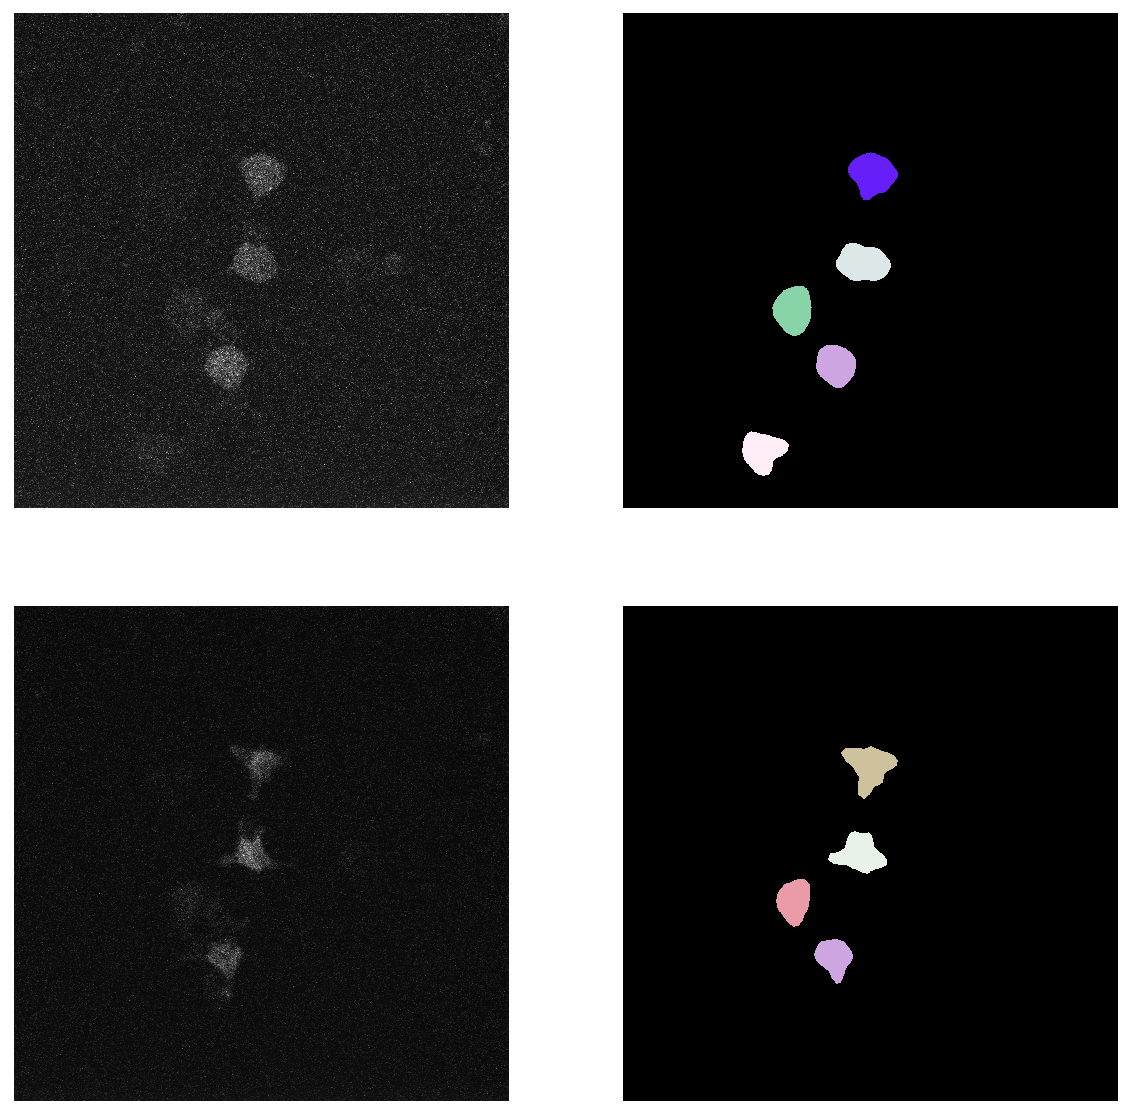

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(221)
img = normalize(X[15],1,99.8,axis=(0,1))
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.subplot(222)
labels, details = model.predict_instances(img)
plt.imshow(labels, cmap=lbl_cmap)
plt.axis('off')
plt.subplot(223)
img = normalize(X[17],1,99.8,axis=(0,1))
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.subplot(224)
labels, details = model.predict_instances(img)
plt.imshow(labels, cmap=lbl_cmap)
plt.axis('off')
plt.show()

In [2]:
def analyze_gcamp(movie, threshold=0.4):
    num_frames = movie.shape[0]
    primary_ch = 1
    secondary_ch = 0
    dim_y = movie.shape[2]
    dim_x = movie.shape[3]

    mask_img = np.zeros((num_frames, dim_y, dim_x))
    tracker = CentroidTracker(maxDisappeared=num_frames)
    data_list = []

    for frame in tqdm(range(num_frames)):
        img = normalize(movie[frame,primary_ch,:,:],1,99.8,axis=(0,1))
        labels, details = model.predict_instances(img, prob_thresh=threshold)
        label_props = measure.regionprops(labels)
        centroids = [props.centroid for props in label_props]
        label_props = {centroid: props for centroid, props in zip(centroids, label_props)}
        objects = tracker.update(centroids)

        for obj, centroid in objects.items():
            try:
                cur_label = label_props[centroid].label
                label_mask = labels==cur_label
                mask_img[frame,label_mask] = obj+1

                area = np.sum(label_mask)
                primary_mean = np.mean(movie[frame,primary_ch,label_mask])
                primary_intden = np.sum(movie[frame,primary_ch,label_mask])
                secondary_mean = np.mean(movie[frame,secondary_ch,label_mask])
                secondary_intden = np.sum(movie[frame,secondary_ch,label_mask])

                data = pd.Series({'frame': frame,
                                  'cell' : obj+1,
                                  'area': area,
                                  'primary_mean' : primary_mean,
                                  'primary_intden' : primary_intden,
                                  'secondary_mean' : secondary_mean,
                                  'secondary_intden' : secondary_intden})
                data_list.append(data)
            except KeyError:
                pass
            
    return mask_img, pd.DataFrame(data_list)

In [4]:
indir = Path.cwd() / 'data' / 'original' / '20191015 PC12 Gcamp'
tifs = []
for root, dirs, files in os.walk(indir):
    for file in files:
        if 'tif' in file:
            tifs.append(Path(root) / file)

In [8]:
data_list = []

for tif in tqdm(tifs):
    movie = imread(str(tif))
    labels, df = analyze_gcamp(movie)
    savedir = tif.parent
    mask_file = savedir / (tif.stem + '_mask.tif')
    data_file = savedir / (tif.stem + '_analysis.csv')
    save_tiff_imagej_compatible(mask_file, labels.astype("uint8"), axes="TYX")
    data_list.append(df)
    df.to_csv(data_file)

In [ ]:
data_list[0].plot.scatter(x='frame',y='secondary_mean',c='cell',colormap='tab10')
plt.title('Mean Intensity Over Time in DOR Channel')
plt.xlabel('frame')
plt.show()

In [ ]:
data_list[0].plot.scatter(x='frame',y='secondary_intden',c='cell',colormap='tab10')
plt.title('Integrated density Over Time in DOR Channel')
plt.xlabel('frame')
plt.show()